# Back Testing Statistics
Chapter 6 of the book: "Build Your Own AI Investor"

In [2]:
from platform import python_version
print(python_version())

3.9.7


In [3]:
import pandas as pd
import numpy as np
import math
import pickle # get the ML model from other notebook
from matplotlib import pyplot as plt # scatter plot
import matplotlib.lines as mlines # plot

In [4]:
# Set the plotting DPI settings to be a bit higher.
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

In [5]:
def loadXandyAgain(randRows=True):
    '''
    Load X and y.
    Randomises rows.
    Returns X, y.
    '''
    # Read in data
    X=pd.read_csv('Annual_Stock_Price_Fundamentals_Ratios.csv',
                  index_col=0)
    y=pd.read_csv('Annual_Stock_Price_Performance_Percentage.csv',
                  index_col=0)
    y=y['Perf'] # We only need the % returns as target
    
    if randRows:
        # randomize the rows
        X['y'] = y
        X = X.sample(frac=1.0, random_state=42) # randomize the rows
        y = X['y']
        X.drop(columns=['y'], inplace=True)

    return X, y

In [6]:
def createYDataForBacktest(y_test):
    '''
    The backtester needs dates from the old y vector.
    This creates a new y DataFrame containing those dates.
    '''
    # Annual stock performances, with date data.
    y_withData=pd.read_csv('Annual_Stock_Price_Performance_Filtered.csv', 
                           index_col=0)

    # Convert to date
    y_withData['Date'] = pd.to_datetime(y_withData['Date'])
    y_withData['Date2'] = pd.to_datetime(y_withData['Date2'])

    # Get y_withData to correspond to y_test
    y_withData_Test=pd.DataFrame()
    y_withData_Test=y_withData.loc[y_test.index, :]

    # Convert string to datetime
    y_withData_Test['Date'] = pd.to_datetime(y_withData_Test['Date'])
    y_withData_Test['Date2'] = pd.to_datetime(y_withData_Test['Date2'])
    
    return y_withData, y_withData_Test

In [7]:
from sklearn.model_selection import train_test_split

def getNewDataForBacktest(random_state=42):
    '''
    Create all the data for a backtest:
    X_train, X_test, y_train, y_test, y_withData, y_withData_Test.
    
    reads files: Annual_Stock_Price_Fundamentals_Ratios.csv,
    Annual_Stock_Price_Performance_Percentage.csv,
    Annual_Stock_Price_Performance_Filtered.csv.
    
    Set a random_state to control the train/test split. Default 42.
    '''
    X, y = loadXandyAgain()
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=random_state)
    y_withData, y_withData_Test = createYDataForBacktest(y_test)
    
    return X_train, X_test, y_train, y_test, y_withData, y_withData_Test

In [8]:
X_train, X_test, y_train, y_test, y_withData, y_withData_Test = getNewDataForBacktest(42)

In [9]:
X_train.head()

,EV/EBIT,Op. In./(NWC+FA),P/E,P/B,P/S,Op. In./Interest Expense,Working Capital Ratio,RoE,ROCE,Debt/Equity,Debt Ratio,Cash Ratio,Asset Turnover,Gross Profit Margin,(CA-CL)/TA,RE/TA,EBIT/TA,Book Equity/TL
15608,25.088187,1.892463,30.787803,100.000000,8.309345,15.365672,0.992100,4.395644,0.336493,25.609800,1.039048,0.500176,7.920565,0.859817,-0.003069,0.000955,0.205770,0.039048
12984,10.091484,0.438757,10.106306,-9.710831,0.663155,4.345765,2.351683,-0.960868,0.265582,0.000000,0.886492,0.157368,12.753286,0.494439,0.316537,-0.085707,0.203388,-0.113508
4585,9.675629,-4.787856,13.771049,4.669563,1.621880,8.677293,0.651565,0.339086,0.295852,1.851320,1.540155,0.247085,15.638219,0.645944,-0.108796,0.325538,0.203475,0.540155
11795,19.068705,0.242455,26.734055,6.676976,2.934750,-600.000000,2.836232,0.249755,0.226205,0.875714,2.141925,1.004400,2.292363,0.518336,0.274266,-0.272696,0.192419,1.141925
12516,-9.524490,-0.016296,-0.393110,0.760208,0.212104,-0.133581,0.219967,-1.933832,-0.094018,15.350187,1.065146,0.065568,0.285433,1.000000,-0.284727,-1.175022,-0.059700,0.065146


In [10]:
X_test.head()

,EV/EBIT,Op. In./(NWC+FA),P/E,P/B,P/S,Op. In./Interest Expense,Working Capital Ratio,RoE,ROCE,Debt/Equity,Debt Ratio,Cash Ratio,Asset Turnover,Gross Profit Margin,(CA-CL)/TA,RE/TA,EBIT/TA,Book Equity/TL
1933,27.984892,0.415935,44.854289,7.318737,3.974482,17.444196,3.330784,0.163167,0.109558,1.821541,1.548986,1.562154,7.445341,0.621314,0.281290,-0.013804,0.096336,0.548986
11215,11.522145,0.196645,17.770079,2.034452,1.127335,12.321385,1.826463,0.114488,0.151735,0.780235,2.281665,0.022093,2.807647,0.479987,0.210725,0.345108,0.113047,1.281665
12225,500.000000,-0.006468,15.567165,2.966159,3.037539,-1.311360,5.591371,0.190539,0.000995,0.177743,6.626086,4.124435,14.096315,0.499838,0.620849,-0.598089,0.000860,5.626086
9258,14.829516,0.121908,26.601143,1.880889,0.372590,2.615108,1.542358,0.070707,0.063131,3.577692,1.279510,0.377857,2.470706,0.405126,0.113615,0.104554,0.049906,0.279510
13616,33.416985,1.148434,100.366490,4.179117,5.030074,-600.000000,1.042428,0.041639,0.101287,0.645387,2.549459,0.649495,10.243371,0.759922,0.012691,0.397277,0.070991,1.549459


In [11]:
y_test.head() # y targets

1933     0.075202
11215    0.404996
12225    0.329741
9258     0.147485
13616   -0.002599
Name: y, dtype: float64

In [12]:
y_withData_Test.head() # y data corresponding to y targets

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
1933,BCR,174.73,2015-02-18,6.629396e+07,BCR,187.87,2016-02-18,6.913860e+07
11215,ORLY,39.63,2010-02-26,6.349915e+07,ORLY,55.68,2011-02-28,8.012352e+07
12225,QTNA,13.92,2018-02-28,4.506739e+06,QTNA,18.51,2019-02-28,7.614551e+06
9258,M,20.68,2010-03-10,2.197043e+08,M,23.73,2011-03-10,1.592093e+08
13616,SNPS,88.50,2017-12-14,8.453786e+07,SNPS,88.27,2018-12-14,9.841231e+07


In [13]:
# Daily stock price time series for ALL stocks. 5M rows. Some days missing.
def getYRawData(directory='C:/Users/G50/Stock_Data/SimFin2021/'):
    '''
    Can set directory to look for file in.
    Get daily stock price time series for ALL stocks. 
    5M rows. Some days missing.
    Returns DataFrame
    '''
    daily_stock_prices=pd.read_csv(directory+'us-shareprices-daily.csv',
                                   delimiter=';')
    daily_stock_prices["Date"]=pd.to_datetime(daily_stock_prices['Date'])
    print('Reading historical time series stock data, matrix size is: ', 
          daily_stock_prices.shape)
    return daily_stock_prices

daily_stock_prices_data=getYRawData()

Reading historical time series stock data, matrix size is:  (6567888, 11)


# Train a model from here for backtest
Otherwise train a model in previous notebook, where data will be loaded into this notebook.

We select stocks in a backtest with a picked, pretrained model.

The the train set trains the mdoel the test set is sent to the backtester.

In [14]:
X_train, X_test, y_train, y_test, y_withData, y_withData_Test = getNewDataForBacktest(42)

# Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rfregressor = RandomForestRegressor(random_state=42, max_depth=10).fit(X_train, y_train)

y_pred = rfregressor.predict(X_test)

print('train mse: ', mean_squared_error(y_train, rfregressor.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))
import pickle # To save the fitted model
pickle.dump(rfregressor, open("rfregressor.p", "wb" ))

train mse:  0.20582791501796052
test mse:  0.5841730014206696


# Backtest Program

In [15]:
def getStockPriceBetweenDates(date1, date2, ticker, 
                              daily_stock_prices):
#     # Alternative way
#     rows = daily_stock_prices[(daily_stock_prices["Date"].between(pd.to_datetime(date1),\
#                                 pd.to_datetime(date2) )) \
#                                  & (daily_stock_prices["Ticker"]==ticker)]
    newRows = pd.DataFrame()
    newRows = daily_stock_prices.loc[(daily_stock_prices["Date"]>date1) &\
                                  (daily_stock_prices["Date"]<date2) &\
                                  (daily_stock_prices["Ticker"]==ticker)]
    newRows.set_index('Date', inplace=True)
    return newRows

In [16]:
def getDataForDateRange(weeklyDateTimeIndex, dailyStockDataRows):
    '''
    Given a date range(index), and a series of rows,
    that may not correspond exactly,
    return a DataFrame that gets rows data,
    for each period in the date range(index)
    '''
    weeklyStockDataRows = pd.DataFrame()
    for weeklyDate in weeklyDateTimeIndex:
        weeklyStockDataRows = pd.concat([weeklyStockDataRows, 
                                         dailyStockDataRows.iloc[dailyStockDataRows.index.get_indexer([weeklyDate],
                                                                                                      method='nearest')]
                                        ])
    return weeklyStockDataRows

In [17]:
def getStockTimeSeries(dateTimeIndex, y_withData, 
                       tickers, daily_stock_prices):
    '''
    Get the stock price as a time series DataFrame for a list of tickers,
    over a dataTimeIndex.
    dateTimeIndex is typically a weekly index.
    '''
    stocksPrices = pd.DataFrame(index=dateTimeIndex)
    weeklyDateTimeIndex = dateTimeIndex.strftime('%Y-%m-%d') # Change Date Format
    
    # For a range of stocks
    for ticker in tickers:
        # For each individual stock
        dailyStockDataRows = getStockPriceBetweenDates(dateTimeIndex[0], 
                                                       dateTimeIndex[-1], 
                                                       ticker, 
                                                       daily_stock_prices)

        weeklyStockDataRows = getDataForDateRange(weeklyDateTimeIndex,
                                                  dailyStockDataRows)
        
        # Append each stock data to the DataFrame
        # Here can use Open, Close, Adj. Close, etc. price
        stocksPrices[ticker] = weeklyStockDataRows["Close"].values
    return stocksPrices

In [18]:
def getPortfolioRelativeTimeSeries(stocksPrices):
    '''
    Takes DataFrame of stock returns, one column per stock
    Normalises all the numbers so the price at the start is 1.
    Adds a column for the portfolio value.
    '''    
    for key in stocksPrices.keys():
        stocksPrices[key]=stocksPrices[key]/stocksPrices[key][0]
    stocksPrices["Portfolio"] = stocksPrices.sum(axis=1)/\
                                    (stocksPrices.keys().shape[0])
    return stocksPrices

In [19]:
# Z score to account for default chance
def calcZScores(X):
    '''
    Calculate Altman Z'' scores 1995
    '''
    Z = pd.DataFrame()
    Z['Z score'] = 3.25 \
    + 6.51 * X['(CA-CL)/TA']\
    + 3.26 * X['RE/TA']\
    + 6.72 * X['EBIT/TA']\
    + 1.05 * X['Book Equity/TL']
    return Z

In [20]:
def getYPerf(y_):
    '''
    To get the y_withData to line up the the Ticker ID
    To get the Ticker ID later
    '''
    y=pd.DataFrame()
    y["Ticker"] = y_["Ticker"]
    y["Perf"]=(y_["Open Price2"]-y_["Open Price"])/y_["Open Price"]
    y[y["Perf"].isnull()]=0
    return y

In [21]:
def getPortTimeSeriesForYear(date_starting, 
                             y_withData, 
                             X, 
                             daily_stock_prices, 
                             ml_model_pipeline,
                             verbose=False):
    '''
    Function runs a backtest.
    Returns DataFrames of selected stocks/portfolio performance,
    for 1 year.
    y_withData is annual stock performances (all backtest years)
    date_starting e.g. '2010-01-01'
    daily_stock_prices is daily(mostly) stock price time series for
    all stocks
    '''
    
    # To get the Ticker ID later
    y_TickerList = getYPerf(y_withData)
    
    # Get performance only for time frame we care about,
    # mask original data using the start date
    thisYearMask = y_withData["Date"].between(\
              pd.to_datetime(date_starting) - pd.Timedelta(days=60),\
              pd.to_datetime(date_starting) )
    if verbose:
        print('Selecting stocks with financial data published between:\n', 
              pd.to_datetime(date_starting) - pd.Timedelta(days=60),
              'and', pd.to_datetime(date_starting),
              'To hold for 1 year.')
    
    if verbose:
        print('Stock Selection from', X[thisYearMask].shape[0], 'stocks')
    # Get return prediction from model
    y_pred = ml_model_pipeline.predict(X[thisYearMask])
       
    # Make a DataFrame to select the top picks
    StockSelectionDF = pd.DataFrame()
    
    StockSelectionDF['ZScore'] = calcZScores(X[thisYearMask])
    StockSelectionDF['Ticker'] = y_TickerList['Ticker'][thisYearMask]
    StockSelectionDF['PredictedReturn'] = y_pred
    
    ticker_list = list(StockSelectionDF[StockSelectionDF['ZScore'] > 2].sort_values(by='PredictedReturn', ascending=False).head(7)['Ticker'])

    if verbose:
        print('Top 20 stocks are:',
             StockSelectionDF[StockSelectionDF['ZScore'] > 2].sort_values(by='PredictedReturn', ascending=False).head(20))

    dateTimeIndex = pd.date_range(\
                          start=date_starting, periods=52, freq='W')
    if verbose:
        print('Selected stocks are: ', ticker_list)

    # Issue with one of the tickers equaling 0, fix with lambda function
    #ticker_list = list(filter(lambda dateTimeIndex: dateTimeIndex != 0, ticker_list))
    
    # After we know our stock picks, we get the stock performance
    # Get DataFrame index of time stamp, series of stock prices, 
    # keys=tickers
    stockRet = getStockTimeSeries(dateTimeIndex, 
                                  y_withData,
                                  ticker_list, 
                                  daily_stock_prices)
    
    # Get DataFrame of relative stock prices from 1st day(or close) 
    # and whole portfolio
    stockRetRel = getPortfolioRelativeTimeSeries(stockRet)
    if verbose:
        print('The return was ', round((stockRetRel['Portfolio'].iloc[-1]-1) * 100, 2), '%')
    return stockRetRel

In [22]:
def getPortTimeSeries(y_withData, 
                      X, 
                      daily_stock_prices, 
                      ml_model_pipeline, 
                      verbose=True):
    '''
    Returns DataFrames of selected stocks/portfolio performance since 2009.
    Needs X and y(with data), the daily_stock_prices DataFrame,
    the model pipeline we want to test.
    X is standard X for model input.
    y_withData is the stock price before/after df with date information.
    Input X and y must be data that the model was not trained on.
    '''
    # set date range to make stock picks over
    # This will be the start year, select stocks with publication within a 
    # time window, ending in March, when all annual reports are in.
    #dr=pd.date_range(start='2009-01-01', periods=10, freq='Y') 
    dr=pd.date_range(start='2009-01-01', 
                     periods=11, 
                     freq='Y') + pd.to_timedelta('9w') # start every March
    # For each date in the date_range, make stock selections
    # and plot the return results of those stock selections
    port_perf_all_years = pd.DataFrame()
    perfRef=1 # performance starts at 1.
    for curr_date in dr:
        
        annualResults = getPortTimeSeriesForYear(curr_date, 
                                                 y_withData, 
                                                 X,
                                                 daily_stock_prices, 
                                                 ml_model_pipeline)
        this_year_perf = annualResults["Portfolio"]
        ticker_list = list(annualResults.keys()[:-1])
        
        if verbose: # If you want text output
            print("Backtest performance for year starting ",\
                  curr_date, " is:",\
                  round((this_year_perf.iloc[-1]-1)*100,2), "%")
            print("With stocks:", ticker_list)
            for tick in ticker_list:
                print(tick, "Performance was:",\
                      round((annualResults[tick].iloc[-1]-1)*100,2), "%" )
            print("---------------------------------------------")
        
        # Stitch performance for every year together
        this_year_perf = this_year_perf * perfRef
        
        port_perf_all_years = pd.concat([port_perf_all_years,\
                                         this_year_perf])
        
        perfRef = this_year_perf.iloc[-1]
    
    # Return portfolio performance for all years
    port_perf_all_years.columns = ["Indexed Performance"]
    return port_perf_all_years

# Try out a single backtest

In [23]:
# backtest data
daily_stock_prices_data=getYRawData()

Reading historical time series stock data, matrix size is:  (6567888, 11)


In [24]:
#pl_linear.p, pl_ElasticNet.p, pl_KNeighbors.p, pl_rfregressor.p, pl_decTree.p, pl_svm.p
#trained_model_pipeline = pickle.load(open("pl_linear.p", "rb" ))
#trained_model_pipeline = pickle.load(open("rfregressor.p", "rb" ))

trained_model_pipeline = pickle.load(open('pl_linear.p', 'rb' )) #rfregressor.p pl_linear.p

backTest = getPortTimeSeries(y_withData_Test, X_test, 
                             daily_stock_prices_data, 
                             trained_model_pipeline)

print('Overall performance is: ', 100 * (backTest["Indexed Performance"][-1]-1), '%')

Backtest performance for year starting  2010-03-04 00:00:00  is: 5.78 %
With stocks: ['BIO', 'MAS', 'HCSG', 'NE', 'GRA', 'ATVI', 'AMGN']
BIO Performance was: 13.29 %
MAS Performance was: -10.03 %
HCSG Performance was: 18.3 %
NE Performance was: 0.23 %
GRA Performance was: 27.99 %
ATVI Performance was: 0.0 %
AMGN Performance was: -9.29 %
---------------------------------------------
Backtest performance for year starting  2011-03-04 00:00:00  is: 6.5 %
With stocks: ['CALX', 'ISIL', 'SNDK', 'DISH', 'ADS', 'VGR', 'AJRD']
CALX Performance was: -50.07 %
ISIL Performance was: -7.73 %
SNDK Performance was: 4.82 %
DISH Performance was: 23.5 %
ADS Performance was: 50.67 %
VGR Performance was: 15.99 %
AJRD Performance was: 8.3 %
---------------------------------------------
Backtest performance for year starting  2012-03-03 00:00:00  is: 25.37 %
With stocks: ['DNB', 'BKNG', 'DDD', 'SVT', 'IDCC', 'FII', 'MOS']
DNB Performance was: -1.07 %
BKNG Performance was: 6.54 %
DDD Performance was: 156.55 %

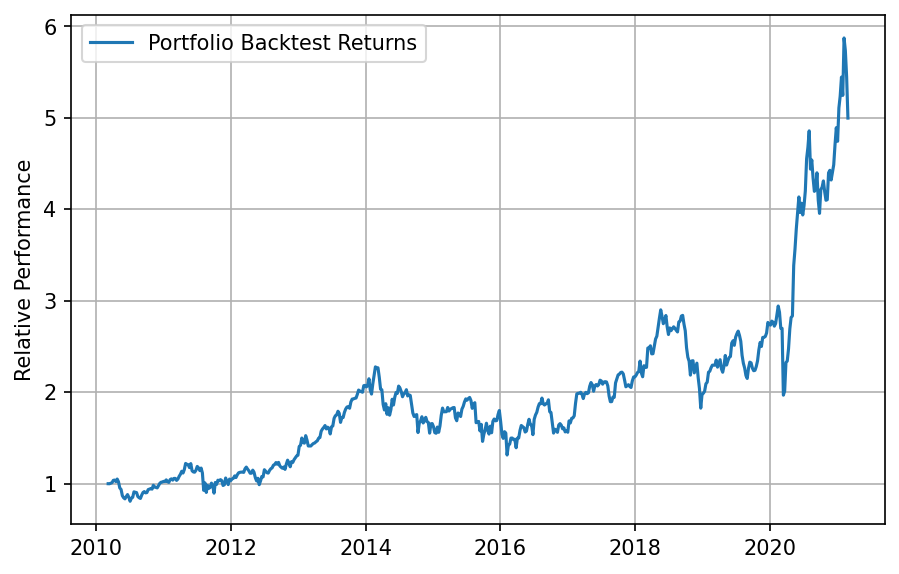

In [25]:
plt.plot(backTest)
plt.grid()
plt.legend(['Portfolio Backtest Returns'])
plt.ylabel('Relative Performance');

# Now loop through model tests and get some statistics to work with.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import pickle

In [25]:
# Linear model pipeline
def trainLinearModel(X_train, y_train):
    pl_linear = Pipeline([('Power Transformer', PowerTransformer()),
        ('linear', LinearRegression())])
    pl_linear.fit(X_train, y_train)
    return pl_linear

# ElasticNet model pipeline
def trainElasticNetModel(X_train, y_train):
    pl_ElasticNet = Pipeline([('Power Transformer', PowerTransformer()),
        ('ElasticNet', ElasticNet(l1_ratio=0.00001))])
    pl_ElasticNet.fit(X_train, y_train)
    return pl_ElasticNet

# KNeighbors regressor
def trainKNeighborsModel(X_train, y_train):
    pl_KNeighbors = Pipeline([('Power Transformer', PowerTransformer()),
        ('KNeighborsRegressor', KNeighborsRegressor(n_neighbors=40))])
    pl_KNeighbors.fit(X_train, y_train)
    return pl_KNeighbors

# DecisionTreeRegressor
def traindecTreeModel(X_train, y_train):
    pl_decTree = Pipeline([
        ('DecisionTreeRegressor',\
         DecisionTreeRegressor(max_depth=20, random_state=42))
    ])
    pl_decTree.fit(X_train, y_train)
    return pl_decTree

# RandomForestRegressor
def trainrfregressorModel(X_train, y_train):
    pl_rfregressor = Pipeline([
        ('RandomForestRegressor',\
         RandomForestRegressor(max_depth=10, random_state=42))
    ])
    pl_rfregressor.fit(X_train, y_train)
    
    return pl_rfregressor

# GradientBoostingRegressor
def traingbregressorModel(X_train, y_train):
    pl_GradBregressor = Pipeline([
        ('GradBoostRegressor',\
         GradientBoostingRegressor(n_estimators=100,\
                                   learning_rate=0.1,\
                                   max_depth=10,\
                                   random_state=42,\
                                   loss='squared_error'))  ])
    pl_GradBregressor.fit(X_train, y_train)
    
    return pl_GradBregressor

# SVM
def trainsvmModel(X_train, y_train):
    pl_svm = Pipeline([('Power Transformer', PowerTransformer()),
        ('SVR', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))])
    pl_svm.fit(X_train, y_train)
    return pl_svm

## Try and find a good train/test split proportion (rough)

In [26]:
# Y percentage perf
y_pec=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", index_col=0)["Perf"]

X=pd.read_csv('Annual_Stock_Price_Fundamentals_Ratios.csv',
              index_col=0)
y=pd.read_csv('Annual_Stock_Price_Performance_Percentage.csv',
              index_col=0)

In [29]:
model_pipeline_list = ['pl_linear', 'pl_KNeighbors', 'pl_decTree',\
                       'pl_GradBregressor', 'pl_rfregressor', 'pl_svm']

for model in model_pipeline_list:
    for myTstSze in [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]:
        X_train,X_test,y_train,y_test=train_test_split(X, y_pec,
                                                       test_size=myTstSze)
        
        if (model =='pl_ElasticNet'):
            model_pl = trainElasticNetModel(X_train, y_train)
        if (model =='pl_KNeighbors'):
            model_pl = trainKNeighborsModel(X_train, y_train)
        if (model =='pl_decTree'):
            model_pl = traindecTreeModel(X_train, y_train)
        if (model =='pl_rfregressor'):
            model_pl = trainrfregressorModel(X_train, y_train)
        if (model =='pl_GradBregressor'):
            model_pl = traingbregressorModel(X_train, y_train)
        if (model =='pl_svm'):
            model_pl = trainsvmModel(X_train, y_train)
        else:
            # Linear model default
            model_pl = trainLinearModel(X_train, y_train) 
            
        y_withData_Test=y_withData.loc[X_test.index]
        
        # Here is our backtesting code
        test = getPortTimeSeries(y_withData_Test, X_test,
                                 daily_stock_prices_data, 
                                 model_pl,
                                 verbose=False) 
        
        perf = test['Indexed Performance'][-1]
        vol = test['Indexed Performance'].diff().std()*np.sqrt(52)
        print('Performance:', round(perf, 2), 
              'Volatility:', round(vol,2),
              'Model', model, 'Test size: ', myTstSze)

Performance: 2.1 Volatility: 0.35 Model pl_linear Test size:  0.02
Performance: 7.16 Volatility: 0.69 Model pl_linear Test size:  0.1
Performance: 3.32 Volatility: 0.59 Model pl_linear Test size:  0.25
Performance: 7.61 Volatility: 0.88 Model pl_linear Test size:  0.5
Performance: 3.53 Volatility: 0.48 Model pl_linear Test size:  0.75
Performance: 7.52 Volatility: 0.85 Model pl_linear Test size:  0.9
Performance: 3.48 Volatility: 0.42 Model pl_linear Test size:  0.98
Performance: 3.86 Volatility: 0.42 Model pl_KNeighbors Test size:  0.02
Performance: 11.79 Volatility: 1.68 Model pl_KNeighbors Test size:  0.1
Performance: 12.14 Volatility: 1.38 Model pl_KNeighbors Test size:  0.25
Performance: 2.99 Volatility: 0.49 Model pl_KNeighbors Test size:  0.5
Performance: 9.87 Volatility: 1.18 Model pl_KNeighbors Test size:  0.75
Performance: 2.12 Volatility: 0.4 Model pl_KNeighbors Test size:  0.9
Performance: 4.22 Volatility: 0.58 Model pl_KNeighbors Test size:  0.98
Performance: 10.21 Volatil

## Now getting the backtesting statistics proper
Can run in parallel, takes awhile.

In [38]:
# Parallel
import os
import threading
import numpy as np
#https://docs.python.org/3/library/threading.html

def addBacktestResults(multithreadingLock,
                       backtestResult, 
                       backtestResultsFileName):
    '''
    Writing backtest results to file without two threads 
    opening the file at same time.
    '''
    multithreadingLock.acquire() # can use "with" too.
    if not os.path.exists(backtestResultsFileName):
        print('Writing backtest number: 0')
        backtestResult.to_csv(backtestResultsFileName)
    else:
        currentWrittenBacktests = pd.read_csv(backtestResultsFileName)
        currTestNumber = currentWrittenBacktests.index[-1]
        print('Writing backtest number:' , currTestNumber)
        backtestResult.to_csv(backtestResultsFileName,
                              mode='a', 
                              header=False)
        
    multithreadingLock.release()
    pass
    
def runBacktestAndSaveResults(multithreadingLock,
                              model_pipeline_list,
                              backtestResultsFileName, 
                              numberOfRunsPerModelPerThread=2):
    '''
    Run a backtest and add results to file.
    '''
    for model in model_pipeline_list:
        for i in range(numberOfRunsPerModelPerThread):
            X_train,X_test,y_train,y_test=train_test_split(X, 
                                                           y_pec,
                                                           test_size=0.5)
            #Train different models
            if (model =='pl_linear'):
                model_pl = trainLinearModel(X_train, y_train)
            if (model =='pl_ElasticNet'):
                model_pl = trainElasticNetModel(X_train, y_train)
            if (model =='pl_KNeighbors'):
                model_pl = trainKNeighborsModel(X_train, y_train)
            if (model =='pl_rfregressor'):
                model_pl = trainrfregressorModel(X_train, y_train)
            if (model =='pl_decTree'):
                model_pl = traindecTreeModel(X_train, y_train)
            if (model =='pl_GradBregressor'):
                model_pl = traingbregressorModel(X_train, y_train)
            if (model =='pl_svm'):
                model_pl = trainsvmModel(X_train, y_train)
            y_withData_Test=y_withData.loc[X_test.index]
            backtestResult = getPortTimeSeries(y_withData_Test, 
                                               X_test,
                                               daily_stock_prices_data, 
                                               model_pl, 
                                               verbose=False)
            singleRunResults = []
            perf = backtestResult['Indexed Performance'][-1]
            vol = backtestResult['Indexed Performance'].diff().std()*np.sqrt(52)

            singleRunResults.append([model, perf, vol])

            # Save our results for plotting
            results_df = pd.DataFrame(singleRunResults, 
                                      columns=["Model Used",
                                               "Indexed Return",
                                               "Annual Volatility"])

            #backtestResult = pd.DataFrame({0:list(np.random.rand(9))})
            addBacktestResults(multithreadingLock,
                               results_df, 
                               backtestResultsFileName)
    pass
        
        
def runParallelBacktests(model_pipeline_list, 
                         numberOfThreads=4,
                         numberOfRunsPerModelPerThread=1,
                         backtestResultsFileName='Backtest_statistics.csv'):
    '''
    Run a bunch of backtests in parallel. 
    Uses a thread lock to prevent two threads opening the file at once.
    '''
    multithreadingLock = threading.Lock()
    thread_list = []
    for i in range(numberOfThreads):
        thread = threading.Thread(target=runBacktestAndSaveResults, 
                                  args=(multithreadingLock,
                                        model_pipeline_list,
                                        backtestResultsFileName, 
                                        numberOfRunsPerModelPerThread))

        thread_list.append(thread)
        thread.start()
        
    return thread_list

In [54]:
# ['pl_linear', 'pl_ElasticNet', 'pl_decTree', 'pl_rfregressor', 'pl_svm', 'pl_KNeighbors', 'pl_GradBregressor']
modelsToRun = ['pl_GradBregressor']
threadList = runParallelBacktests(modelsToRun,
                                  numberOfThreads=24,
                                  numberOfRunsPerModelPerThread=25,
                                  backtestResultsFileName='Backtest_statistics_allmodels_altman3.csv')

In [61]:
# Can check if threads are still running any time.
# Notebook will look as though nothing is running
# But things are running in background.
for t in threadList:
    print(t.is_alive())

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


# Investigating Backtest Statistics

In [27]:
def plotBacktestDist(results_df, model_file, col):
    ax=results_df[results_df['Model Used']==model_file][col].hist(\
                                    bins=50, density=True, alpha=0.7)
    
    ax2=results_df[results_df['Model Used']==model_file][col].plot.kde(\
                                    alpha=0.9)
    
    max_val=results_df[results_df['Model Used']==model_file][col].max()
    ax.set_xlabel(col)
    ax.set_ylabel('Normalised Frequency')
    ax.set_title('{} Backtest Distribution for {}, {} Runs'.format(\
          col,\
          model_file,\
          results_df[results_df['Model Used']==model_file][col].size))
    ax.grid()
    mean=results_df[results_df['Model Used']==model_file][col].mean()
    ymin, ymax = ax.get_ylim()
    
    if (col=='Indexed Return'): 
        # Plot S&P 500 returns
        # begin 2010 -> end 2020
        ax.plot([3.4, 3.4], [ymin, ymax],\
                color='r', linestyle='-', linewidth=1.5, alpha=1)
        ax.plot([mean, mean], [ymin, ymax],\
                color='lime', linestyle='--', linewidth=1.5, alpha=1)
        plt.xlim(0, 30)
    
    if (col=='Annual Volatility'): 
        # Plot S&P 500 volatility
        # begin 2010 -> end 2020
        ax.plot([0.33, 0.33], [ymin, ymax],\
                color='r', linestyle='-', linewidth=2)  
        ax.plot([mean, mean], [ymin, ymax],\
                color='lime', linestyle='--', linewidth=2)  
        plt.xlim(0, 3)
    ax.legend(['Fitted Smooth Kernel','S&P500 Benchmark', \
               'Simulation Mean {}'.format(round(mean,2)),\
               'Simulation Backtests'])

In [28]:
results_df = pd.read_csv('Backtest_statistics_allmodels_altman3.csv', index_col=0)
#results_df = pd.read_csv('Backtest_statistics_altman4.csv', index_col=0)
results_df.reset_index(inplace=True, drop=True)
results_df.head(10)

,Model Used,Indexed Return,Annual Volatility
0,pl_linear,2.094350,0.414867
1,pl_linear,3.182186,0.360410
2,pl_linear,3.915440,0.526966
3,pl_linear,10.807988,1.443955
4,pl_linear,2.490061,0.386387
5,pl_linear,5.368014,0.816877
6,pl_linear,3.679013,0.524808
7,pl_linear,2.827321,0.478205
8,pl_ElasticNet,3.733184,0.667205
9,pl_linear,4.852809,0.588119


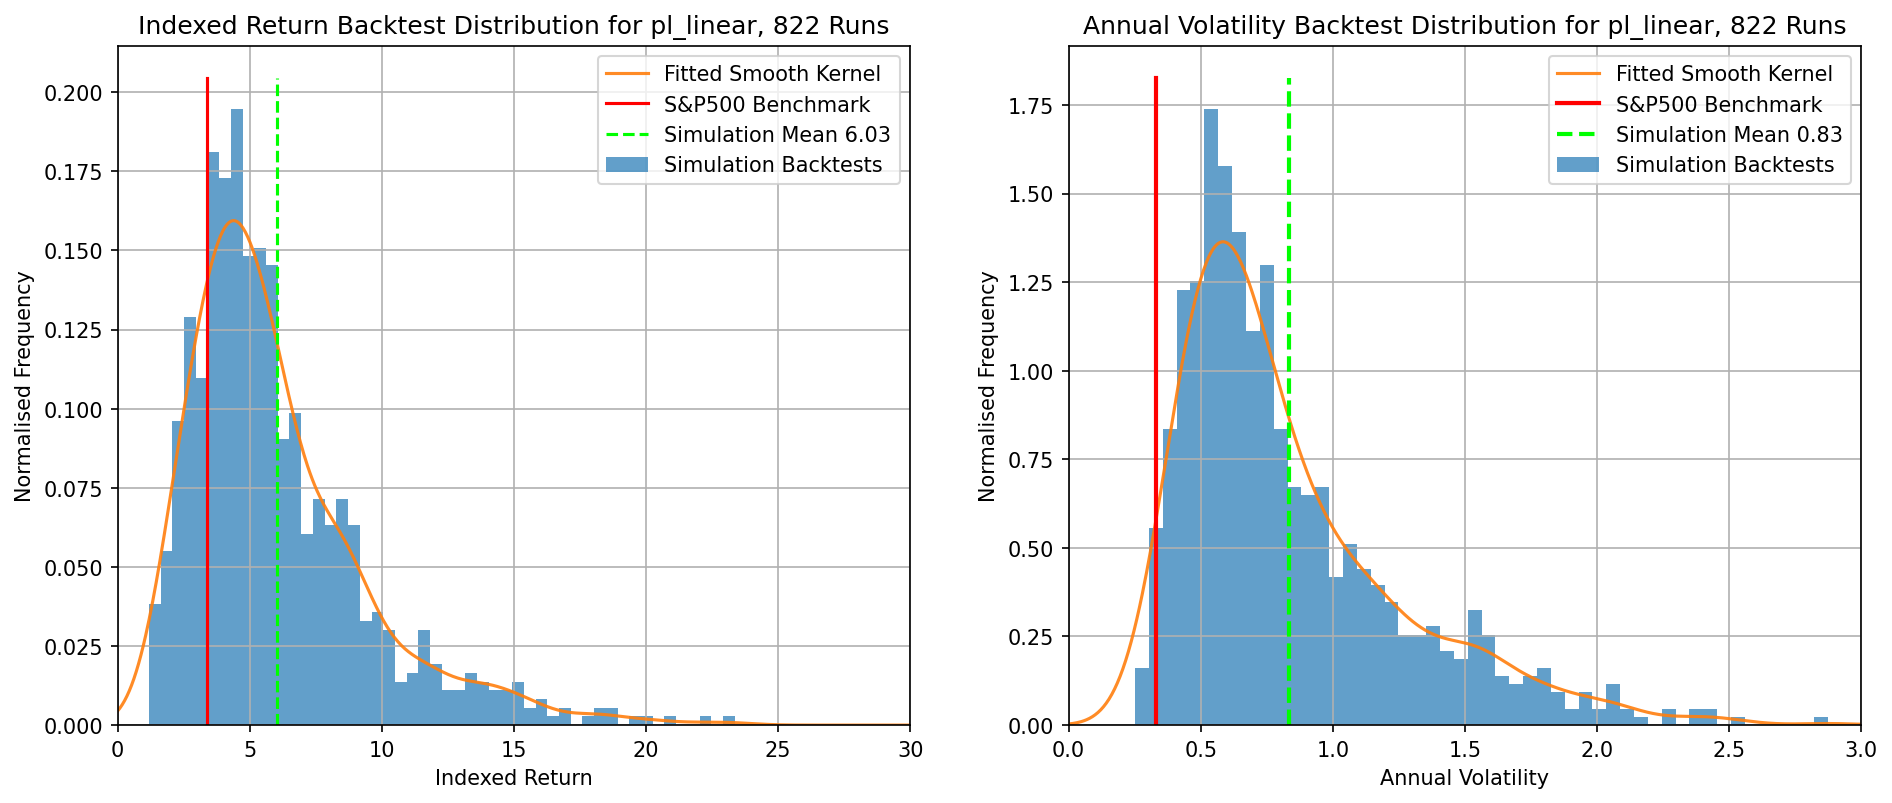

In [29]:
model_file = 'pl_linear'#['pl_linear', 'pl_ElasticNet', 'pl_rfregressor', 'pl_decTree', 'pl_svm', 'pl_KNeighbors']
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plotBacktestDist(results_df, model_file, 'Indexed Return')
plt.subplot(1,2,2)
plotBacktestDist(results_df, model_file, 'Annual Volatility')

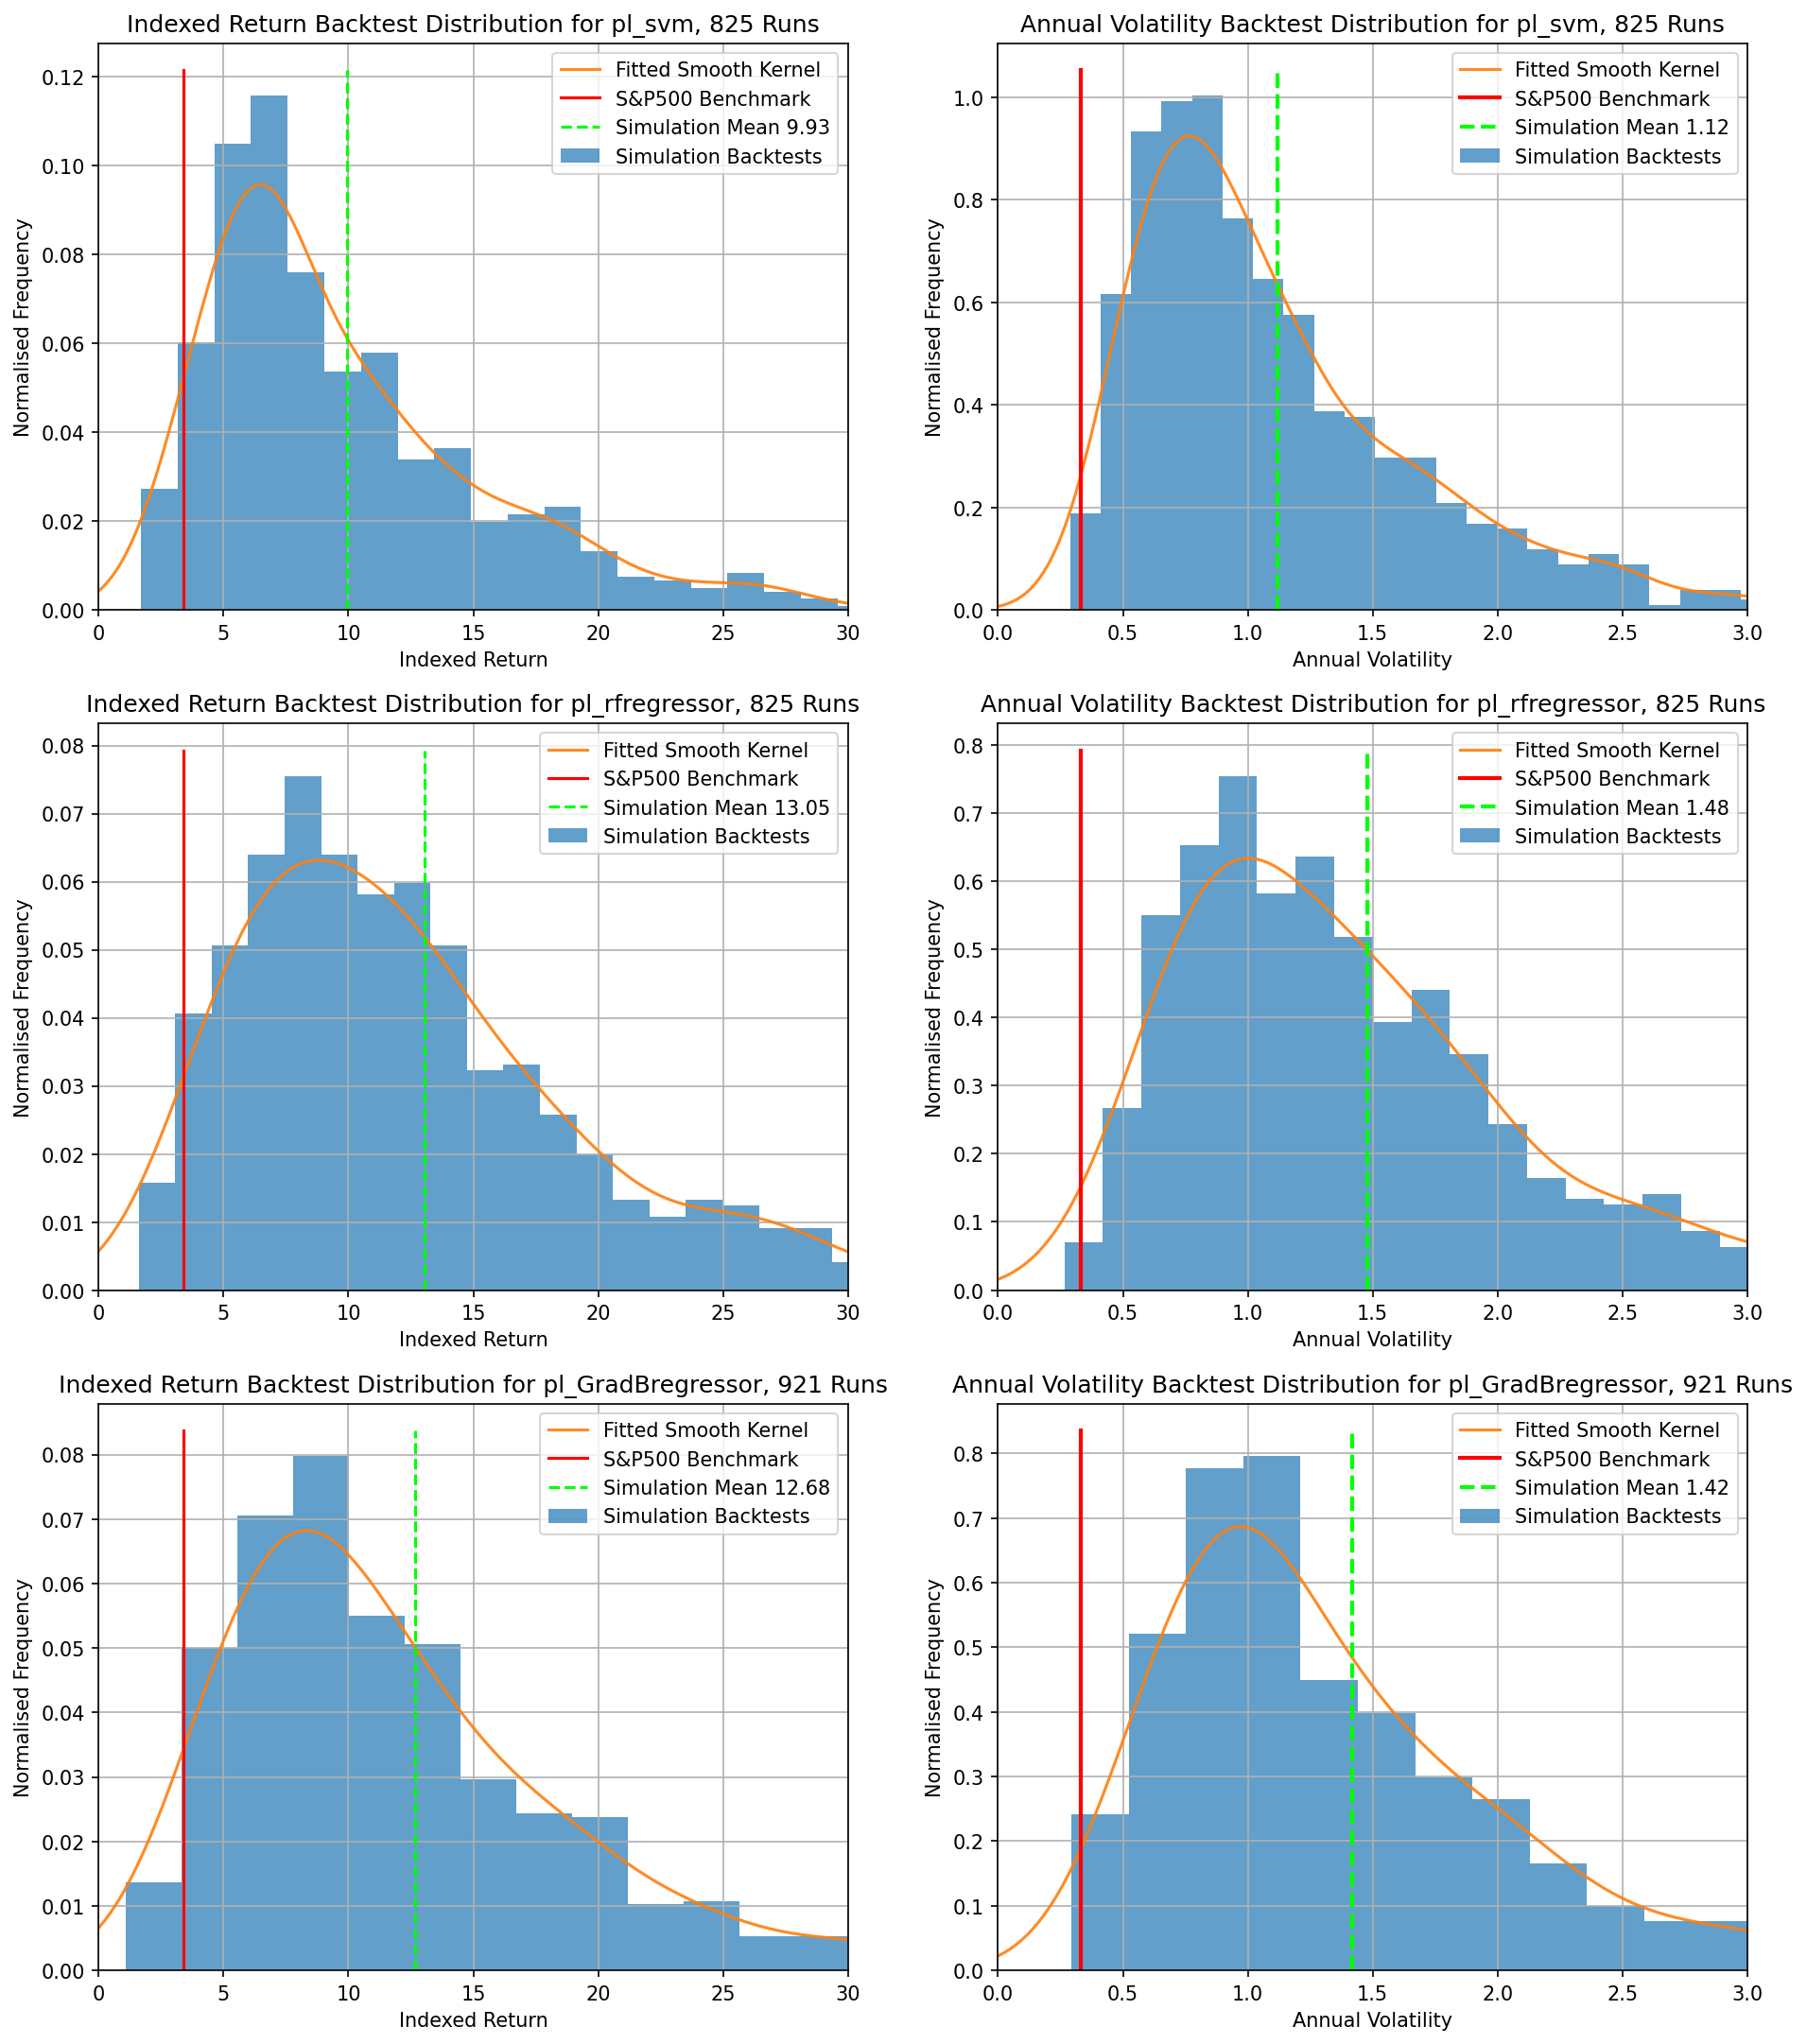

In [34]:
model_file = ['pl_ElasticNet', 'pl_decTree', 'pl_KNeighbors']
model_file = ['pl_svm', 'pl_rfregressor', 'pl_GradBregressor']
#model_file = ['pl_ElasticNet','pl_decTree', 'pl_rfregressor', 'pl_svm', 'pl_KNeighbors', 'pl_GradBregressor']
numPlots = len(model_file)
plt.figure(figsize=(15,6*numPlots))
for I in range(0, numPlots):
    plt.subplot(numPlots,2,I*2+1)
    plotBacktestDist(results_df, model_file[I], 'Indexed Return')
    plt.subplot(numPlots,2,I*2+2)
    plotBacktestDist(results_df, model_file[I], 'Annual Volatility')

# Chosen Regressors for AI are GradBoost and KNN

We will expect more volatility.

(0.0, 2.0)

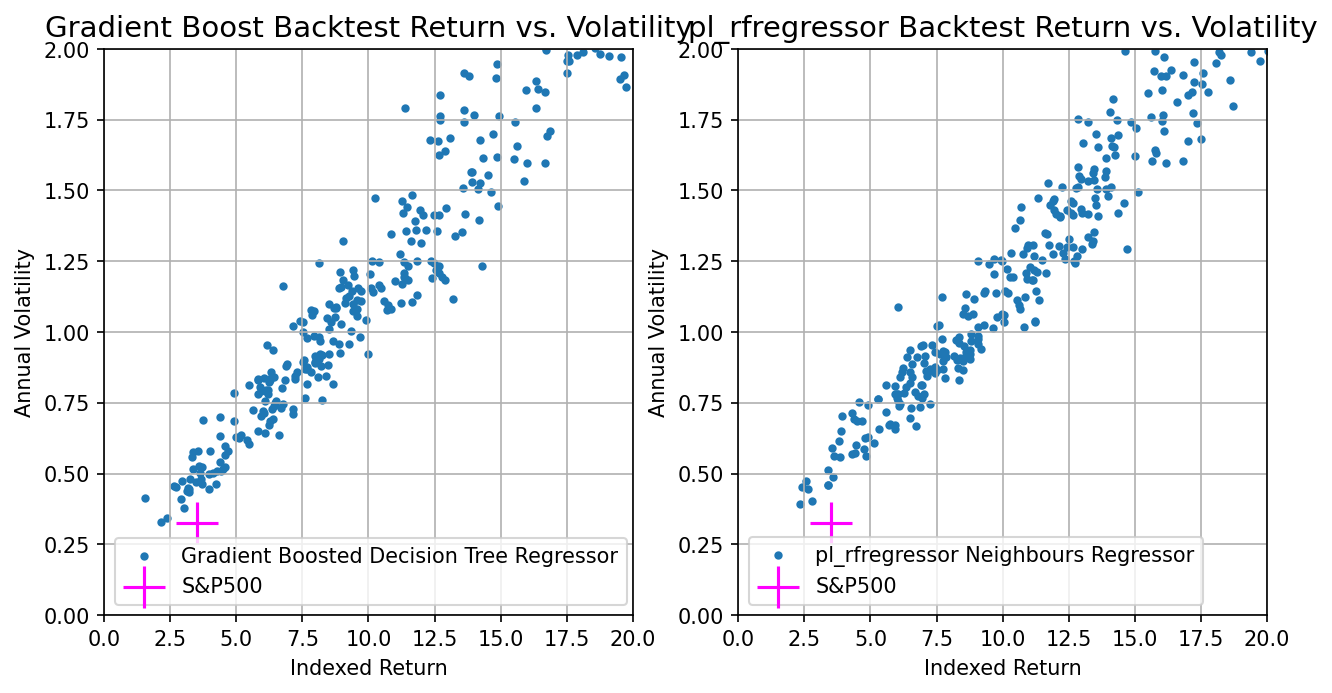

In [71]:
# GRAPH OF RETURN VS VOLATILITY
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
returns = results_df[results_df['Model Used']=='pl_GradBregressor']['Indexed Return']
vols = results_df[results_df['Model Used']=='pl_GradBregressor']['Annual Volatility']
plt.scatter(returns, vols, marker='.')
plt.scatter(3.511822, 0.325059094152396, marker='+', color='fuchsia', s=400)
plt.xlabel('Indexed Return')
plt.ylabel('Annual Volatility')
plt.grid()
plt.legend(['Gradient Boosted Decision Tree Regressor', 'S&P500'])
plt.title('Gradient Boost Backtest Return vs. Volatility', fontsize=14)
plt.xlim([0, 20])
plt.ylim([0,2])

plt.subplot(1,2,2)
returns = results_df[results_df['Model Used']=='pl_rfregressor']['Indexed Return']
vols = results_df[results_df['Model Used']=='pl_rfregressor']['Annual Volatility']
plt.scatter(returns, vols, marker='.')
plt.scatter(3.511822, 0.325059094152396, marker='+', color='fuchsia', s=400)
plt.xlabel('Indexed Return')
plt.ylabel('Annual Volatility')
plt.grid()
plt.legend(['pl_rfregressor Neighbours Regressor', 'S&P500'])
plt.title('pl_rfregressor Backtest Return vs. Volatility', fontsize=14)
plt.xlim([0, 20])
plt.ylim([0,2])

Text(0.5, 0, 'Annual Volatility')

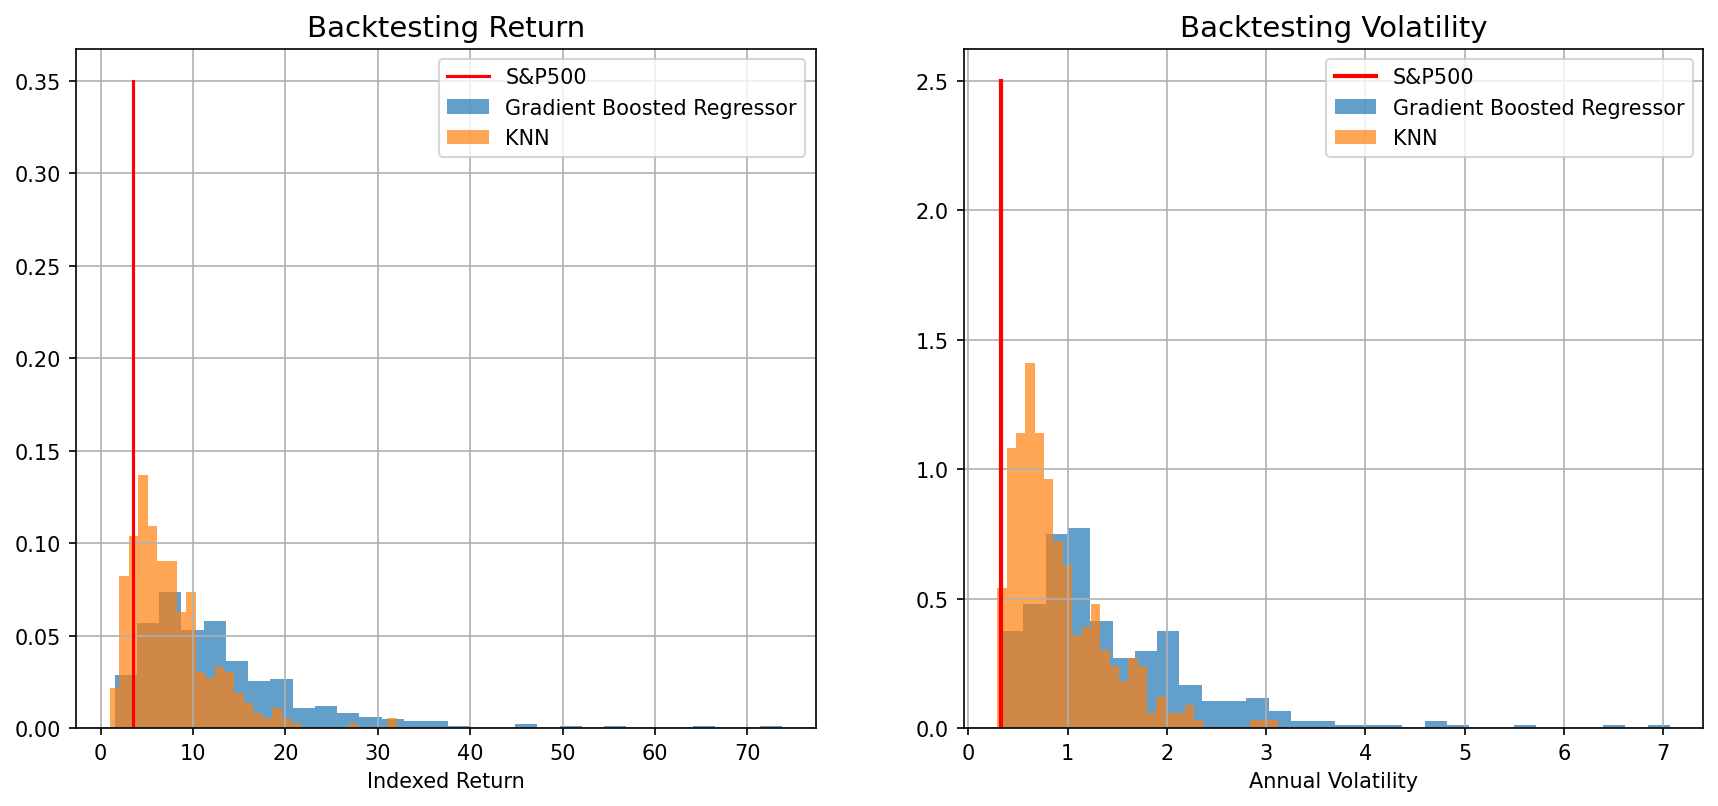

In [73]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
results_df[results_df['Model Used']=='pl_GradBregressor']['Indexed Return'].hist(bins=30,\
                                                density=True, alpha=0.7)
results_df[results_df['Model Used']=='pl_KNeighbors']['Indexed Return'].hist(bins=30,\
                                                density=True, alpha=0.7)
plt.plot([3.511822, 3.511822], [0, 0.35],\
                 color='r', linestyle='-', linewidth=1.5, alpha=1)
plt.legend(['S&P500','Gradient Boosted Regressor', 'KNN'])
plt.title('Backtesting Return', fontsize=14)
plt.xlabel('Indexed Return')

plt.subplot(1,2,2)
results_df[results_df['Model Used']=='pl_GradBregressor']['Annual Volatility'].hist(bins=30,\
                                                density=True, alpha=0.7)
results_df[results_df['Model Used']=='pl_KNeighbors']['Annual Volatility'].hist(bins=30,\
                                                density=True, alpha=0.7)
plt.plot([0.325059094152396, 0.325059094152396], [0, 2.5],\
                color='r', linestyle='-', linewidth=2)  
plt.legend(['S&P500','Gradient Boosted Regressor', 'KNN'])
plt.title('Backtesting Volatility', fontsize=14)
plt.xlabel('Annual Volatility')